In [3]:
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

In [4]:
iris = datasets.load_iris()
features = iris.data 
target = iris.target

sepal_length = np.array(features[:, 0])
petal_width = np.array(features[:, 3])

species_names = list()

for i in target:
    if i == 0:
        species_names.append('setosa')
    elif i == 1:
        species_names.append('versicolor')
    else:
        species_names.append('virginica')

In [22]:
def predict(intercept, coefficient, x):
    return intercept + coefficient * x

def sgd(x, y, epochs, df, alpha = 0.01):
    intercept = 1.0
    coefficient = -7.5
    sum_error = 0

    for i in range(epochs):
        # get random index
        index = np.random.randint(0, len(x))
        # get random x and y
        x_i, y_i = x[index], y[index]
        # get prediction
        prediction = predict(intercept, coefficient, x)
        b0_error = prediction - y_i
        b1_error = (prediction - y_i) * x_i

        intercept = intercept - alpha * b0_error
        coefficient = coefficient - alpha * b1_error 

        sum_error = sum_error + (((prediction - y_i) ** 2) / 2)
        df.loc[i] = [intercept, coefficient, sum_error]
    return df

In [27]:
epochs = 100000
sgd_loss = pd.DataFrame(columns=['intercept', 'coefficient', 'sum_error'])
sgd_loss = sgd(sepal_length, petal_width, epochs = epochs, df = sgd_loss)

KeyboardInterrupt: 

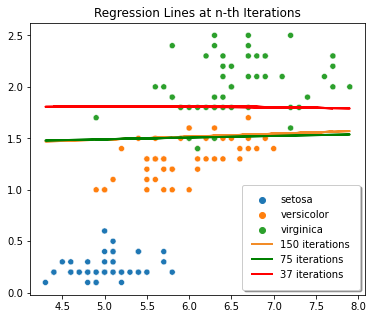

In [ ]:
maxx = epochs-1
half = int(epochs / 2)
quarter = int(epochs / 4)

plt.figure(figsize=(6,5))

sns.scatterplot(
    x = sepal_length, 
    y = petal_width, 
    hue = species_names
)

plt.plot(
    sepal_length, 
    sgd_loss['intercept'][maxx] + sgd_loss['coefficient'][maxx] * sepal_length,
    '#f28c28',
    linewidth = 2,
    label = f'{maxx + 1} iterations'
)

plt.plot(
    sepal_length, 
    sgd_loss['intercept'][half] + sgd_loss['coefficient'][half] * sepal_length,
    '-g',
    linewidth = 2,
    label = f'{half} iterations'
)

plt.plot(
    sepal_length, 
    sgd_loss['intercept'][quarter] + sgd_loss['coefficient'][quarter] * sepal_length,
    '-r',
    linewidth = 2,
    label = f'{quarter} iterations'
)

plt.title("Regression Lines at n-th Iterations")

plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)